## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [19]:
train.shape

(42000, 785)

In [20]:
test.shape

(28000, 784)

In [4]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
test_img.shape

(28000, 28, 28)

## Визуализируем исходные данные

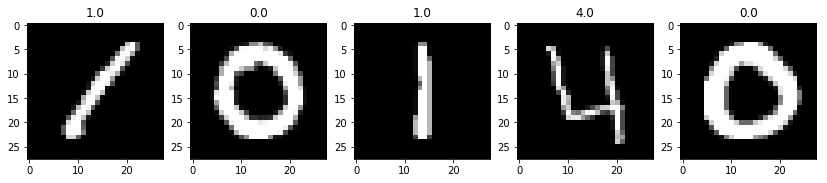

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [30]:
y = train_label
X = train_img.reshape(-1, 28 * 28)
X_test = test_img.reshape(-1, 28 * 28)

# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

X_mean_test = X_test.mean(axis=0)
X_test -= X_mean_test

In [32]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]
cov_test = np.dot(X_test.T, X_test) / X_test.shape[0]

In [34]:
U, S, _ = np.linalg.svd(cov)
U_test, S_test, _ = np.linalg.svd(cov_test)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

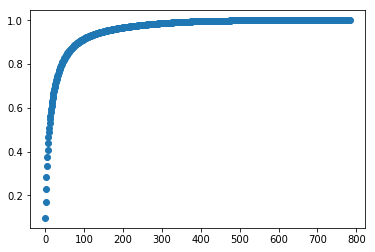

In [35]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
S_test_cumsum = np.cumsum(S_test) / np.sum(S_test)
plt.plot(S_cumsum, 'o')

In [11]:
S_thr = 0.95  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=153 S=0.950


In [36]:
S_thr = 0.95  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp_test = np.argmax(np.where(S_test_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp_test, S_cumsum[n_comp_test]))

n_comp=152 S=0.950


In [37]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])
Xrot_reduced_test = np.dot(X_test, U_test[:, :n_comp_test])

In [38]:
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)
Xrot_restored_test = np.dot(Xrot_reduced_test, U_test[:,:n_comp_test].T)

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True).fit(Xrot_restored)
x_train_pca = pca.transform(Xrot_restored)
x_train_pca.shape

(42000, 153)

In [41]:
x_test_pca = pca.transform(Xrot_restored_test)
x_test_pca.shape

(28000, 153)

In [22]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, x_train_pca, test_size=0.2,
    random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
tree = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=10, random_state=42)
tree.fit(x_train,y_train)
pred_val = tree.predict(x_val)
print('Accuracy: %s' % tree.score(x_val,y_val))

Accuracy: 0.9311904761904762


In [42]:
pred_val_test = tree.predict(x_test_pca)

## Оцениваем качество решение на валидационной выборке

In [24]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9311904761904762


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       816
         1.0       0.98      0.99      0.98       909
         2.0       0.94      0.91      0.93       846
         3.0       0.89      0.90      0.90       937
         4.0       0.93      0.93      0.93       839
         5.0       0.91      0.90      0.91       702
         6.0       0.94      0.97      0.95       785
         7.0       0.94      0.93      0.94       893
         8.0       0.91      0.89      0.90       835
         9.0       0.91      0.91      0.91       838

   micro avg       0.93      0.93      0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



In [165]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[793   0   1   1   1   1  12   2   4   1]
 [  0 894   5   4   1   1   2   0   2   0]
 [  4   4 784  12  11   2   3   6  19   1]
 [  3   1  13 852   2  16   3  11  24  12]
 [  2   2   1   0 783   5  12   6   4  24]
 [  3   0   1  14   7 656  12   1   6   2]
 [  9   1   1   1   0  10 763   0   0   0]
 [  1   9  12   1   5   1   0 831   6  27]
 [  1   4   6  34   5  21   3   3 747  11]
 [  4   4   5  17  19   6   0  18   3 762]]


## Визуализируем предсказания

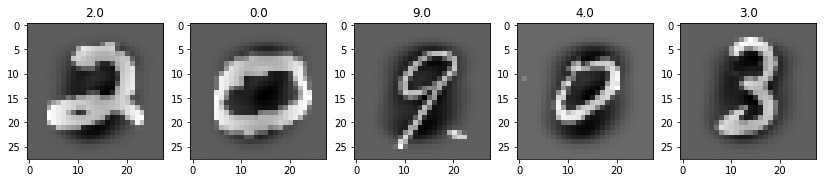

In [43]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_val_test[i - 1]);

## Готовим файл для отправки

In [48]:
with open('digit5.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_val_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [49]:
!head digit5.txt

ImageId,Label
1,2
2,0
3,9
4,4
5,3
6,7
7,0
8,3
9,0
